In [1]:
import networkx as nx
import numpy as np
import itertools as it
import random
import time
import scipy
from matplotlib import pyplot as plt
import fresnel
import os
import PIL

In [2]:
np.random.seed(100)
random.seed(100)

In [3]:
def coordination_pattern(x):
    """
    To do: obtain the neighbors of an input atom position
    Args:
        x: the position of atoms
    Returns:
        the neighbors of the atoms, excluding the center atoms
    """
    return np.array([x+np.array([0.5,0.5,0]),
                     x+np.array([-0.5,0.5,0]),
                     x+np.array([0.5,-0.5,0]),
                     x+np.array([-0.5,-0.5,0]),
                     x+np.array([0.5,0,0.5]),
                     x+np.array([0.5,0,-0.5]),
                     x+np.array([-0.5,0,0.5]),
                     x+np.array([-0.5,0,-0.5]),
                     x+np.array([0,0.5,0.5]),
                     x+np.array([0,-0.5,0.5]),
                     x+np.array([0,0.5,-0.5]),
                     x+np.array([0,-0.5,-0.5]),
                    ])
def neighbors(x):
    """
    To do: obtain the occupied sites for a given cell
    Args:
        x: the position of cells
    Returns:
        the occupied sites in the cells
    """
    #define sites of fcc cell where x is the body center
    return np.array([x+np.array([0.5,0,0]),
                     x+np.array([-0.5,0,0]),
                     x+np.array([0,-0.5,0]),
                     x+np.array([0,0.5,0]),
                     x+np.array([0,0,0.5]),
                     x+np.array([0,0,-0.5]),      
                     x+np.array([0.5,0.5,0.5]),
                     x+np.array([-0.5,-0.5,0.5]),
                     x+np.array([0.5,-0.5,0.5]),
                     x+np.array([-0.5,0.5,0.5]),           
                     x+np.array([0.5,0.5,-0.5]),
                     x+np.array([-0.5,-0.5,-0.5]),
                     x+np.array([0.5,-0.5,-0.5]),
                     x+np.array([-0.5,0.5,-0.5])   
                    ])
    

In [4]:
#define the kinetic constant for simulation
k_Au=-5.4
k_Ag=-4.6
Energy_ratio=0.7
Energy_ratio2=0.1
k_on_Au=0.700000
k_on_Ag=1.000000
random_seed = 42

path="/mnt/orkney/Chemobot/Nanobot-Monte_Carlo_Simulation/Au_Ag_7_traj/example_{}_{}_{}_{}_{}_{}_{}/".format(k_Au,k_Ag,Energy_ratio,Energy_ratio2,k_on_Au,k_on_Ag,random_seed)

In [5]:
# read in the initial structure
initial_atom_strucutre = np.loadtxt("/home/yibin/workspace/Growth_with_silverV3/atomList_TruncatedOctahedron.csv",delimiter=",")
initial_atom_strucutre = initial_atom_strucutre-np.array([0.5,0.5,0.5]) # slight movement

In [6]:
# get the trajecotry
count = 500000
site_temp_record_total = np.load(path+"structure/"+"site_temp_record_total%d.npy"%count,allow_pickle = True)
atom_type_record_total = np.load(path+"structure/"+"atom_type_record_total%d.npy"%count,allow_pickle = True)

In [7]:
# calculate the extra atom positions
# slight movement
extra_atom_sites = np.array([site_temp_record_total[i][0] for i in range(len(site_temp_record_total))]) - np.array([0.5,0.5,0.5])
event_indexes = np.array([site_temp_record_total[i][1] for i in range(len(site_temp_record_total))])
# the atomic sites that appeared in the trajecotry should be recorded
final_structure = np.unique(np.vstack((initial_atom_strucutre,extra_atom_sites)),axis=0)

In [8]:
# calculate the potential dipole site position for the given structure 
min_range = np.around(final_structure.min())
max_range = np.around(final_structure.max())
interval = 1.5
sites = min_range+np.arange(int((max_range-min_range)/interval)+3)*interval-interval

dipole_positions = []
for x in sites:
    for y in sites:
        for z in sites:
            dipole_positions.append([x,y,z])
dipole_positions = np.array(dipole_positions)

In [9]:
atom_lower = int(np.floor(dipole_positions.min()))
atom_upper = int(np.ceil(dipole_positions.max()))
ideal_atom_position = []
for x in range(atom_lower,atom_upper+int(3*np.ceil(interval))):
    for y in range(atom_lower,atom_upper+int(3*np.ceil(interval))):
        for z in range(atom_lower,atom_upper+int(3*np.ceil(interval))):
            ideal_atom_position.append([x,y,z])
ideal_atom_position = np.array(ideal_atom_position)
ideal_atom_position = np.unique(neighbors(ideal_atom_position).reshape(-1,3),axis=0).tolist()

In [10]:
# validate all the corresponding atoms were captured by the ideal case
final_structure = final_structure.tolist()
flag = 0
for i in final_structure:
    if not (i in ideal_atom_position):
        print('error!')

In [11]:
# the first output should be the subset of the second output
# the second output should be the subset of the third output
print(f'{np.array(final_structure).min()}_{np.array(final_structure).max()}')
print(f'{np.array(dipole_positions).min()}_{np.array(dipole_positions).max()}')
print(f'{np.array(ideal_atom_position).min()}_{np.array(ideal_atom_position).max()}')

-13.0_31.5
-14.5_33.5
-15.5_39.5


# Check fully occupied atom numbers

In [ ]:
# get the fully occupied dipole number for the ideal case
dipole_full_number = [] # calculate with the ideal atomic position
dipole_full_number2 = [] # directly calculated by the atoms between dipoles
# iterate through all the existing dipole positions
for dipole_position_temp in dipole_positions:
    lower = np.floor(dipole_position_temp)
    upper = np.ceil(dipole_position_temp+interval)
    position = []
    for x in range(int(lower[0]),int(upper[0])+1):
        for y in range(int(lower[1]),int(upper[1])+1):
            for z in range(int(lower[2]),int(upper[2])+1):
                position.append([x,y,z])
    position = np.unique(neighbors(position).reshape(-1,3),axis=0)
    in_dipole_interval = np.all((dipole_position_temp<=position)*(position<=dipole_position_temp+interval),axis=1)
    position = position[in_dipole_interval]
    dipole_full_number.append(sum([i.tolist() in ideal_atom_position for i in position]))
    dipole_full_number2.append(len(position))

In [26]:
sum(abs(np.array(dipole_full_number)-32))
# this indicates the cell contains 32 dipoles to fill it up

0

# Get the dipoles that get involved in the whole transformation process

In [12]:
# get the fully occupied dipole number for the ideal case
dipole_current_coord = []
# iterate through all the existing dipole positions
for dipole_position_temp in dipole_positions:
    lower = np.floor(dipole_position_temp)
    upper = np.ceil(dipole_position_temp+interval)
    position = []
    for x in range(int(lower[0]),int(upper[0])+1):
        for y in range(int(lower[1]),int(upper[1])+1):
            for z in range(int(lower[2]),int(upper[2])+1):
                position.append([x,y,z])
    position = np.unique(neighbors(position).reshape(-1,3),axis=0)
    in_dipole_interval = np.all((dipole_position_temp<=position)*(position<=dipole_position_temp+interval),axis=1)
    position = position[in_dipole_interval]
    dipole_current_coord.append(sum([i.tolist() in final_structure for i in position]))

In [13]:
dipole_positions = dipole_positions[np.array(dipole_current_coord)==32]

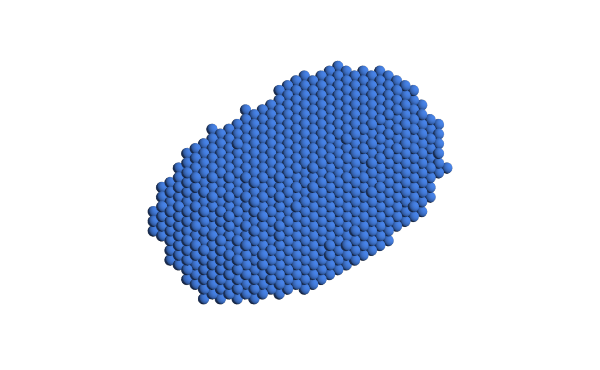

In [14]:
scene = fresnel.Scene()
geometry1 = fresnel.geometry.Sphere(scene, N=len(dipole_positions), radius=np.sqrt(2)/2)
geometry1.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]),
                                              roughness=0.8)

geometry1.position[:] = dipole_positions
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

# Initialize the atom coordinates

In [15]:
initial_atom_strucutre = initial_atom_strucutre.tolist()
# get the fully occupied dipole number for the ideal case
dipole_current_coord = []
# iterate through all the existing dipole positions
for dipole_position_temp in dipole_positions:
    lower = np.floor(dipole_position_temp)
    upper = np.ceil(dipole_position_temp+interval)
    position = []
    for x in range(int(lower[0]),int(upper[0])+1):
        for y in range(int(lower[1]),int(upper[1])+1):
            for z in range(int(lower[2]),int(upper[2])+1):
                position.append([x,y,z])
    position = np.unique(neighbors(position).reshape(-1,3),axis=0)
    in_dipole_interval = np.all((dipole_position_temp<=position)*(position<=dipole_position_temp+interval),axis=1)
    position = position[in_dipole_interval]
    dipole_current_coord.append(sum([i.tolist() in initial_atom_strucutre for i in position]))

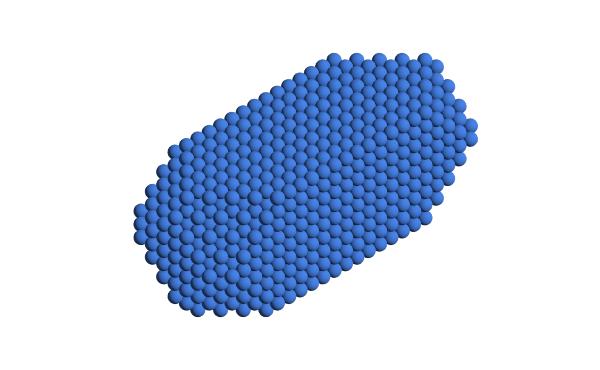

In [16]:
scene = fresnel.Scene()
geometry1 = fresnel.geometry.Sphere(scene, N=len(dipole_positions[np.array(dipole_current_coord)==32]), radius=np.sqrt(2)/2)
geometry1.material = fresnel.material.Material(color=fresnel.color.linear([0.25,0.5,0.9]),
                                              roughness=0.8)

geometry1.position[:] = dipole_positions[np.array(dipole_current_coord)==32]
scene.camera = fresnel.camera.Orthographic.fit(scene)
fresnel.preview(scene)

In [17]:
np.savetxt(f'./dipole_positions_{random_seed}.csv',dipole_positions,delimiter=',')
np.savetxt(f'./dipole_current_coord_{random_seed}.csv',dipole_current_coord,delimiter=',')

# Loop through the event

In [18]:
# read in the generated dipole position
dipole_positions = np.loadtxt(f'./dipole_positions_{random_seed}.csv',delimiter=',')
# read in the calculated atom number inside the dipoles
dipole_current_coord = np.loadtxt(f'./dipole_current_coord_{random_seed}.csv',delimiter=',')
# get the trajecotry information
count = 500000
site_temp_record_total = np.load(path+"structure/"+"site_temp_record_total%d.npy"%count,allow_pickle = True)
atom_type_record_total = np.load(path+"structure/"+"atom_type_record_total%d.npy"%count,allow_pickle = True)
# calculate the extra atom positions
# slight movement
extra_atom_sites = np.array([site_temp_record_total[i][0] for i in range(len(site_temp_record_total))]) - np.array([0.5,0.5,0.5])
event_indexes = np.array([site_temp_record_total[i][1] for i in range(len(site_temp_record_total))])

In [19]:
# get the number of Au/Ag atoms in the dipole
coord_infor = {}
count = 0
for dipole_position_temp in dipole_positions:
    coord_infor[tuple(dipole_position_temp)] = {}
    coord_infor[tuple(dipole_position_temp)]['coord'] = [dipole_current_coord[count],0]
    if sum(coord_infor[tuple(dipole_position_temp)]['coord']) == 32:
        coord_infor[tuple(dipole_position_temp)]['type'] = 'dipole'
    else:
        coord_infor[tuple(dipole_position_temp)]['type'] = 'vacant'
    count = count + 1
dipole_positions = dipole_positions.tolist()

In [20]:
np.random.seed(random_seed)
events = []
# get the change of the nanostructures through the atomic changes
for i in range(len(extra_atom_sites)):
    extra_atom_site_tmp = extra_atom_sites[i]
    # get the sites that is involved by this atomic site
    dipole_site = []
    site_x = sites[(sites>=(extra_atom_site_tmp[0] - interval))*(sites<=(extra_atom_site_tmp[0]))]
    site_y = sites[(sites>=(extra_atom_site_tmp[1] - interval))*(sites<=(extra_atom_site_tmp[1]))]
    site_z = sites[(sites>=(extra_atom_site_tmp[2] - interval))*(sites<=(extra_atom_site_tmp[2]))]
    for x in site_x:
        for y in site_y:
            for z in site_z:
                dipole_site.append([x,y,z])
    np.random.shuffle(dipole_site)
                
    if event_indexes[i] == 0:
        # addition event
        for dipole_site_temp in dipole_site:
            if dipole_site_temp in dipole_positions:
                if atom_type_record_total[i] == 'Au':
                    coord_infor[tuple(dipole_site_temp)]['coord'][0] = coord_infor[tuple(dipole_site_temp)]['coord'][0] + 1
                else:
                    coord_infor[tuple(dipole_site_temp)]['coord'][1] = coord_infor[tuple(dipole_site_temp)]['coord'][1] + 1
                # judge if a new dipole should be added after the addition event
                if coord_infor[tuple(dipole_site_temp)]['coord'][0] + coord_infor[tuple(dipole_site_temp)]['coord'][1] ==32:
                    events.append([dipole_site_temp,
                                   coord_infor[tuple(dipole_site_temp)]['coord'].copy(),
                                   'add',
                                   atom_type_record_total[i]])
                    print(i)
                    coord_infor[tuple(dipole_site_temp)]['type']='dipole'
                            
    # replacement
    elif event_indexes[i] == 1:
        for dipole_site_temp in dipole_site:
            if dipole_site_temp in dipole_positions:
                if atom_type_record_total[i] == 'Au':
                    # judge the event type and atom type
                    coord_infor[tuple(dipole_site_temp)]['coord'][0] = coord_infor[tuple(dipole_site_temp)]['coord'][0] - 1
                    coord_infor[tuple(dipole_site_temp)]['coord'][1] = coord_infor[tuple(dipole_site_temp)]['coord'][1] + 1
                else:
                    # judge the event type and atom type
                    coord_infor[tuple(dipole_site_temp)]['coord'][0] = coord_infor[tuple(dipole_site_temp)]['coord'][0] + 1
                    coord_infor[tuple(dipole_site_temp)]['coord'][1] = coord_infor[tuple(dipole_site_temp)]['coord'][1] - 1
                    
                if coord_infor[tuple(dipole_site_temp)]['coord'][0] + coord_infor[tuple(dipole_site_temp)]['coord'][1] ==32:
                    # Replace the Au dipole with Ag dipole
                    events.append([dipole_site_temp,
                                   coord_infor[tuple(dipole_site_temp)]['coord'].copy(),
                                   'replace',
                                   atom_type_record_total[i]])
                    print(i)
    else:
        # deletion event
        for dipole_site_temp in dipole_site:
            if dipole_site_temp in dipole_positions:
                # judge the event type and atom type
                if atom_type_record_total[i] == 'Au':
                    coord_infor[tuple(dipole_site_temp)]['coord'][0] = coord_infor[tuple(dipole_site_temp)]['coord'][0] - 1
                else:
                    coord_infor[tuple(dipole_site_temp)]['coord'][1] = coord_infor[tuple(dipole_site_temp)]['coord'][1] - 1
                if coord_infor[tuple(dipole_site_temp)]['type'] != 'vacant':
                    events.append([dipole_site_temp,
                                   coord_infor[tuple(dipole_site_temp)]['coord'].copy(),
                                   'delete',
                                   atom_type_record_total[i]])
                    coord_infor[tuple(dipole_site_temp)]['type'] = 'vacant'
                    print(i)

1
1
2
2
7
18
27
27
27
27
30
42
42
42
42
58
60
60
63
66
66
80
80
82
90
110
117
117
121
126
133
133
141
147
159
160
162
163
166
166
169
185
188
188
189
190
195
196
196
214
215
215
216
217
217
225
225
232
232
232
232
245
245
248
248
253
265
265
274
279
279
279
279
285
288
294
295
295
295
295
308
308
313
316
317
322
325
325
326
340
340
346
349
349
349
349
350
365
365
365
365
370
370
375
379
379
388
394
395
401
407
409
409
413
415
418
418
425
425
431
431
432
436
439
441
444
444
456
456
458
465
485
485
491
491
493
509
509
512
518
524
524
527
527
541
543
554
554
555
556
566
566
579
579
581
589
593
593
601
602
603
604
604
612
613
615
616
616
619
619
625
627
627
629
629
629
629
632
632
636
636
641
642
645
652
652
656
656
658
658
665
673
687
701
704
722
725
727
727
728
728
730
733
745
752
752
767
774
775
788
788
798
798
803
803
804
810
815
820
820
820
820
834
834
843
843
844
846
857
869
869
873
873
882
883
887
887
902
902
903
903
904
904
916
916
916
916
922
922
927
927
934
935
941
941
943
944
94

5831
5835
5835
5838
5838
5841
5841
5841
5841
5843
5846
5849
5852
5852
5853
5855
5855
5855
5855
5862
5862
5862
5866
5872
5879
5889
5890
5894
5907
5917
5917
5919
5921
5921
5921
5921
5923
5925
5925
5936
5938
5940
5940
5952
5952
5953
5953
5954
5955
5957
5958
5968
5968
5968
5968
5973
5974
5977
5977
5978
5987
5991
6007
6008
6008
6026
6035
6035
6036
6037
6037
6044
6047
6051
6054
6054
6057
6057
6060
6060
6060
6062
6062
6071
6071
6072
6074
6074
6075
6079
6086
6087
6089
6091
6105
6107
6107
6109
6111
6116
6116
6119
6122
6122
6122
6127
6147
6148
6148
6154
6163
6163
6172
6172
6175
6175
6182
6187
6195
6199
6199
6199
6202
6202
6202
6202
6214
6215
6221
6221
6229
6233
6235
6236
6236
6236
6236
6243
6251
6253
6260
6263
6263
6265
6276
6276
6281
6289
6289
6289
6289
6292
6300
6300
6300
6300
6303
6303
6306
6306
6316
6329
6329
6332
6332
6335
6345
6345
6366
6368
6372
6373
6373
6373
6373
6374
6374
6377
6378
6381
6396
6398
6403
6406
6409
6410
6410
6410
6410
6414
6415
6418
6420
6420
6430
6432
6435
6436
6439
6441


12577
12586
12586
12587
12588
12596
12597
12597
12609
12612
12618
12622
12631
12638
12645
12645
12673
12676
12688
12688
12695
12697
12702
12705
12720
12721
12726
12732
12732
12734
12736
12740
12741
12742
12747
12747
12747
12747
12749
12751
12757
12770
12771
12772
12772
12772
12779
12782
12788
12795
12798
12799
12803
12808
12812
12822
12823
12824
12843
12844
12847
12848
12849
12855
12855
12862
12862
12872
12872
12872
12872
12876
12876
12881
12893
12900
12900
12904
12904
12904
12904
12906
12914
12917
12924
12924
12927
12927
12936
12936
12938
12938
12938
12938
12941
12943
12943
12954
12956
12964
12967
12983
12985
12992
12994
13014
13015
13018
13018
13028
13032
13045
13047
13063
13064
13064
13080
13080
13080
13080
13084
13085
13091
13091
13097
13097
13097
13097
13098
13098
13098
13098
13104
13114
13121
13121
13126
13126
13127
13131
13148
13148
13152
13170
13173
13177
13183
13203
13209
13209
13217
13218
13218
13237
13238
13242
13248
13248
13248
13248
13250
13260
13263
13264
13264
13268
1326

19762
19769
19795
19801
19805
19818
19825
19827
19837
19842
19842
19865
19865
19873
19890
19896
19901
19904
19912
19912
19912
19913
19913
19916
19916
19928
19928
19937
19960
19964
19964
19973
19976
19990
20005
20005
20016
20016
20026
20027
20027
20043
20045
20045
20053
20053
20054
20054
20056
20056
20057
20065
20065
20086
20091
20098
20100
20103
20114
20114
20116
20116
20120
20128
20129
20133
20147
20147
20159
20159
20166
20173
20176
20183
20191
20191
20194
20199
20204
20222
20231
20235
20239
20239
20239
20252
20252
20252
20253
20267
20271
20277
20277
20278
20279
20279
20290
20329
20342
20362
20362
20369
20378
20385
20389
20389
20398
20401
20403
20417
20436
20448
20450
20450
20450
20450
20451
20452
20452
20452
20469
20469
20473
20476
20476
20479
20487
20495
20503
20505
20512
20518
20519
20521
20530
20531
20531
20535
20535
20540
20543
20560
20560
20564
20564
20564
20564
20569
20574
20574
20581
20591
20608
20612
20631
20631
20646
20646
20659
20670
20677
20688
20688
20695
20695
20696
2071

29889
29897
29917
29918
29923
29945
29960
29976
29983
29989
29992
29998
30015
30018
30026
30028
30042
30049
30050
30062
30071
30086
30086
30092
30092
30096
30098
30098
30121
30131
30135
30152
30156
30159
30161
30165
30184
30221
30228
30234
30237
30254
30259
30261
30264
30289
30292
30296
30296
30301
30308
30318
30318
30318
30318
30348
30348
30353
30358
30375
30404
30408
30411
30433
30452
30455
30455
30476
30505
30510
30511
30513
30529
30542
30550
30554
30571
30571
30574
30583
30587
30597
30608
30611
30613
30627
30643
30673
30675
30675
30675
30693
30704
30704
30704
30704
30705
30707
30707
30718
30721
30750
30767
30768
30777
30777
30803
30808
30812
30823
30823
30828
30831
30834
30836
30850
30861
30866
30876
30889
30889
30889
30892
30901
30904
30907
30917
30929
30929
30929
30946
30947
30948
30950
30955
30961
30982
30993
30993
30997
31000
31013
31015
31016
31020
31020
31052
31053
31058
31080
31084
31094
31094
31098
31100
31104
31105
31109
31121
31152
31161
31161
31169
31173
31194
31202
3120

39061
39065
39071
39079
39083
39091
39099
39105
39105
39105
39123
39124
39138
39140
39142
39147
39158
39162
39166
39176
39177
39177
39177
39179
39187
39201
39203
39216
39218
39218
39231
39232
39232
39239
39240
39255
39260
39260
39260
39260
39280
39282
39288
39288
39294
39294
39294
39306
39309
39328
39330
39334
39334
39342
39345
39354
39357
39360
39360
39361
39375
39375
39376
39376
39392
39393
39405
39413
39413
39413
39413
39420
39423
39427
39428
39434
39437
39437
39440
39444
39445
39447
39450
39454
39454
39478
39487
39487
39491
39491
39495
39495
39504
39508
39518
39528
39529
39529
39539
39539
39547
39549
39549
39552
39559
39569
39575
39577
39584
39587
39588
39590
39590
39596
39618
39618
39621
39637
39645
39651
39651
39657
39657
39668
39668
39669
39674
39677
39687
39704
39716
39723
39730
39738
39759
39762
39768
39774
39777
39782
39792
39796
39798
39798
39799
39807
39810
39816
39816
39816
39823
39823
39833
39835
39842
39842
39842
39853
39882
39882
39883
39886
39892
39895
39896
39899
3989

46565
46570
46575
46576
46576
46577
46578
46579
46594
46603
46607
46607
46618
46621
46621
46625
46628
46628
46628
46641
46641
46654
46665
46669
46673
46675
46678
46678
46679
46679
46679
46684
46685
46699
46709
46715
46716
46721
46722
46727
46728
46730
46735
46740
46768
46773
46788
46800
46815
46822
46830
46835
46839
46839
46843
46844
46844
46844
46851
46861
46872
46877
46879
46880
46892
46895
46904
46905
46926
46927
46927
46935
46936
46938
46938
46940
46945
46945
46945
46945
46954
46954
46956
46958
46965
46966
46967
46977
46992
46993
46994
46996
46998
47005
47007
47010
47012
47016
47016
47018
47018
47022
47025
47026
47033
47039
47044
47044
47044
47080
47082
47091
47093
47097
47100
47103
47106
47109
47115
47122
47125
47125
47126
47128
47151
47151
47156
47161
47162
47166
47166
47183
47190
47196
47199
47199
47200
47200
47202
47204
47204
47204
47208
47218
47225
47225
47225
47229
47231
47231
47237
47237
47251
47258
47262
47262
47262
47270
47282
47283
47283
47285
47285
47297
47314
47321
4732

54504
54508
54544
54561
54569
54572
54581
54584
54595
54595
54597
54598
54624
54624
54624
54624
54631
54631
54642
54650
54659
54668
54681
54714
54715
54715
54715
54742
54748
54753
54758
54760
54773
54777
54777
54783
54799
54799
54802
54817
54817
54854
54858
54858
54863
54886
54886
54893
54906
54908
54916
54930
54936
54955
54955
54969
54969
54970
54974
54978
54979
54981
54986
54986
54995
54999
55005
55006
55006
55007
55031
55031
55053
55077
55077
55079
55094
55101
55118
55119
55128
55129
55131
55137
55138
55141
55141
55142
55147
55148
55149
55149
55149
55149
55152
55161
55161
55175
55184
55186
55188
55195
55195
55202
55202
55204
55209
55211
55212
55212
55215
55220
55221
55221
55245
55247
55247
55252
55260
55260
55264
55276
55279
55280
55283
55294
55297
55304
55307
55307
55346
55350
55350
55352
55360
55377
55392
55396
55397
55402
55402
55410
55413
55421
55430
55443
55443
55469
55469
55475
55475
55484
55487
55500
55541
55548
55548
55548
55548
55551
55553
55558
55560
55566
55580
55581
5558

64004
64015
64017
64041
64041
64043
64056
64068
64070
64078
64093
64093
64099
64108
64114
64115
64122
64122
64124
64124
64124
64124
64130
64138
64138
64139
64141
64151
64157
64174
64186
64194
64196
64200
64208
64223
64224
64224
64228
64237
64265
64278
64279
64298
64300
64303
64304
64311
64327
64352
64376
64393
64405
64406
64406
64406
64406
64420
64450
64451
64451
64452
64478
64478
64478
64480
64480
64480
64481
64486
64490
64499
64504
64511
64518
64518
64520
64529
64536
64536
64536
64541
64541
64547
64552
64557
64572
64572
64572
64572
64579
64580
64580
64595
64607
64613
64646
64669
64677
64677
64682
64696
64696
64713
64737
64754
64756
64782
64804
64815
64816
64821
64826
64828
64838
64856
64865
64877
64882
64891
64906
64915
64925
64925
64932
64932
64935
64935
64940
64944
64965
64974
64978
64980
64993
64995
65002
65010
65013
65013
65022
65053
65064
65064
65070
65074
65101
65103
65104
65106
65107
65117
65123
65131
65131
65144
65144
65144
65144
65150
65151
65167
65171
65175
65175
65178
6518

In [21]:
np.save(f'./event_{random_seed}.npy',events)

/home/yibin/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [22]:
import pickle
with open(f'./coord_infor_{random_seed}.pickle', 'wb') as handle:
    pickle.dump(coord_infor, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
events

[[[-4.0, -2.5, 26.0], [31.0, 1], 'replace', 'Au'],
 [[-2.5, -2.5, 26.0], [31.0, 1], 'replace', 'Au'],
 [[-2.5, -8.5, 14.0], [31.0, 1], 'replace', 'Au'],
 [[-2.5, -8.5, 12.5], [31.0, 1], 'replace', 'Au'],
 [[-5.5, -8.5, 5.0], [31.0, 1], 'replace', 'Au'],
 [[0.5, -2.5, 26.0], [31.0, 1], 'replace', 'Au'],
 [[-4.0, -8.5, 11.0], [31.0, 1], 'replace', 'Au'],
 [[-5.5, -8.5, 9.5], [31.0, 1], 'replace', 'Au'],
 [[-4.0, -8.5, 9.5], [31.0, 1], 'replace', 'Au'],
 [[-5.5, -8.5, 11.0], [31.0, 1], 'replace', 'Au'],
 [[-8.5, -1.0, -5.5], [31.0, 1], 'replace', 'Au'],
 [[-5.5, -8.5, 12.5], [31.0, 1], 'replace', 'Au'],
 [[-4.0, -8.5, 14.0], [31.0, 1], 'replace', 'Au'],
 [[-4.0, -8.5, 12.5], [31.0, 1], 'replace', 'Au'],
 [[-5.5, -8.5, 14.0], [31.0, 1], 'replace', 'Au'],
 [[5.0, 3.5, -2.5], [31.0, 1], 'replace', 'Au'],
 [[3.5, -8.5, 3.5], [31.0, 1], 'replace', 'Au'],
 [[3.5, -8.5, 5.0], [31.0, 1], 'replace', 'Au'],
 [[-8.5, 0.5, 21.5], [31.0, 1], 'replace', 'Au'],
 [[-1.0, -8.5, 8.0], [31.0, 1], 'replace',

In [24]:
len(events)

12757